In [130]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
from scipy.stats import levene
import pingouin as pg
plt.style.use('ggplot')

In [4]:
  # Загружаем данные 
active_users = pd.read_csv('https://stepik.org/media/attachments/lesson/426730/active_users.csv')
active_users.head()

user_id country platform     sex
0     8029  Russia      ios    male
1     1735  Sweden      ios    male
2     7697  Russia  android    male
3     1421  Sweden  android  female
4     1704  Russia      ios    male

In [5]:
groups = pd.read_csv('https://stepik.org/media/attachments/lesson/426730/groups.csv')
groups.head()

user_id group
0     9149     B
1     9150     B
2     9151     A
3     9152     B
4     9153     B

In [7]:
purchases = pd.read_csv('https://stepik.org/media/attachments/lesson/426730/purchases.csv')
purchases.head()

user_id  revenue
0     4412   1000.0
1     9000    701.0
2     9001    700.0
3     9002    702.0
4     5790   1002.0

In [15]:
  # Объединяем данные в единый датафрейм 
df = active_users.merge(purchases,  on = 'user_id')\
            .merge(groups, on = 'user_id')
df.head()

user_id country platform     sex  revenue group
0     1202  Sweden  android    male    302.0     A
1     6284  Russia  android  female    208.0     B
2     6554  Sweden  android  female    602.0     B
3     6000  Sweden      ios    male   1910.0     B
4     4046  Sweden      ios  female   1909.0     B

In [34]:
  # Проверяем соотношение наблюдений в тестовой и контрольной группе 
print('Количество наблюдений в контрольной группе {}'.format(control.shape[0]))
print('Количество наблюдений в тестовой группе {}'.format(test.shape[0]))
print('Соотношение между контрольной и тестовой группой {}/{}'.format(round(control.shape[0]/(test.shape[0] + control.shape[0]) * 100), 
                                                                     round(test.shape[0]/(test.shape[0] + control.shape[0]) * 100)))

Количество наблюдений в контрольной группе 78
Количество наблюдений в тестовой группе 314
Соотношение между контрольной и тестовой группой 20/80


Объем выборок существенно отличается. Необходимо проверить пропорцию различных показателей в сегментах контрольной и тестовой группы

In [104]:
  # Соотношение посетителей из Швеции к посетителям из России в группах
print('Соотношение посетителей из Швеции и России в контрольной группе {}'
      .format(round(control.country.value_counts()[1] / control.country.value_counts()[0], 2)))
print('Соотношение посетителей из Швеции и России в тестовой группе {}'
        .format(round(test.country.value_counts()[1] / test.country.value_counts()[0], 2)))

Соотношение посетителей из Швеции и России в контрольной группе 0.81
Соотношение посетителей из Швеции и России в тестовой группе 0.59


In [113]:
  # Соотношение пользователей с браузером ios к пользователям с браузером android в группах
print('Соотношение браузеров ios и android в контрольной группе {}'
           .format(round(control.platform.value_counts()[1] / control.platform.value_counts()[0], 2)))
print('Соотношение браузеров ios и android в тестовой группе {}'
           .format(round(test.platform.value_counts()[1] / test.platform.value_counts()[0], 2)))

Соотношение браузеров ios и android в контрольной группе 1.0
Соотношение браузеров ios и android в тестовой группе 0.86


In [115]:
  # Соотношение пользователей женщин к пользователям мужчинам в группах
print ('Соотношение пользователей женщин и пользователей мужчин в контрольной группе {}'
           .format(round(control.sex.value_counts()[1] / control.sex.value_counts()[0], 2)))
print ('Соотношение пользователей женщин и пользователей мужчин в тестовой группе {}'
           .format(round(test.sex.value_counts()[1] / test.sex.value_counts()[0], 2)))

Соотношение пользователей женщин и пользователей мужчин в контрольной группе 0.9
Соотношение пользователей женщин и пользователей мужчин в тестовой группе 0.96


В целом соотношение сегментов в двух группах приблизительно одинаково. Теперь посмотрим на распределение в группах 

C:\Users\georg\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='revenue', ylabel='Density'>

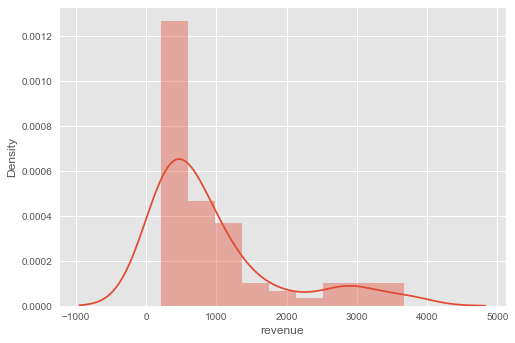

In [125]:
  # Посмотрим на распределение в контрольной группе
sns.distplot(control.revenue)

C:\Users\georg\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='revenue', ylabel='Density'>

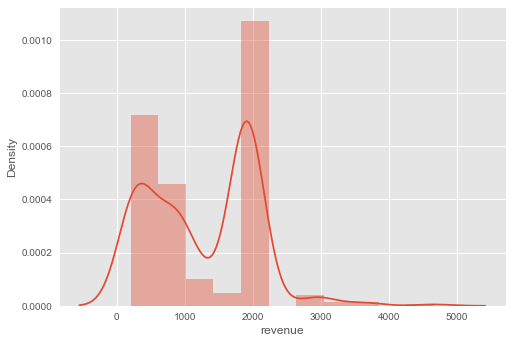

In [126]:
  # Посмотрим на распределение в тестовой группе 
sns.distplot(test.revenue)

В обеих группах распределение ассиметричное, отличное от нормального, значительная часть наблюдений находится в левой части графика

В качестве метрики следует выбрать показатель ARPU (среднее значение дохода на посетителя). Данная метрика позволит узнать есть ли статистически значимое увеличение в доходе на посетителя в тестовой грппе

В качестве критерия сравнения показателей в группах можно выбрать t-критерий Стьюдента для двух независимых выборок. Данный критерий устойчив к распределениям отличным от нормального, если количество наблюдений в группах > 30 

Однако перед тем как применить t-критерий необходимо сравнить дисперсии в группах, для этого воспользуемся тестом Левена

In [129]:
  # pvalue выше уровня значимости в 0.05, следовательно между дисперсиями в тестовой и контрольной группе нет
  # статистически значимых отличий 
  # мы можем применить t- критерий Стьюдента
scipy.stats.levene(control.revenue, test.revenue)

LeveneResult(statistic=3.07680546419023, pvalue=0.08020177652122025)

In [101]:
  # Однако сначала 
  # Необходимо проверить достаточно ли у нас данных для достижения необходимого уровня 
  # статистической мощности критерия  power > 80
  # Для начала найдем размер эффекта 
effect_size = pg.compute_effsize(control.revenue, test.revenue, eftype='cohen')
effect_size

-0.39649215869110244

In [102]:
  # Теперь расчитаем стат мощность t- критерия при полученных данных
  # В качестве уровня значимости будем использовать порог 0.05
  # В качестве размера эффекта полученное значение (0.39)
from pingouin import power_ttest2n
power_ttest2n(nx=78, ny=314, d = effect_size, alpha=0.05)

0.8782623098888096

Таким образом, у нас достаточно данных для эффективного использования t критерия (статистической мощностью > 80). Используем t-критерий

In [133]:
  # Порог статистической значимости 0.05
  # Нулевая гипотеза - между среднем значением прибыли (ARPU) в контрольной и тестовой группе нет различий 
  # Альтернативная гипотеза - средние значения прибыли (ARPU) в контрольной и тестовой группе отличаются 
scipy.stats.ttest_ind(control.revenue, test.revenue)

Ttest_indResult(statistic=-3.134033935298925, pvalue=0.0018546337642145053)

p_value оказался меньше 0.05, следовательно результаты t- критерия Стьюдента показывают наличие статистически значимых отличий между ARPU (среднем значением прибыли) в контрольной и тестовой группе

Отклоняем нулевую гипотезу о равенстве ARPU в двух группах

## Вывод

Результаты t- критерия Стьюдента показали стат значимые отличия между ARPU в тестовой и контрольной группе

Таким образом, следует принять новую модель оплаты шаблонов, так как она приносит больше дохода на посетителя (ARPU), чем старая версия